In [1]:
import os
import random
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tqdm import trange

from rfa import random_forest_attack

In [2]:
# Load MNIST dataset from OpenML
FILE_NAME = 'mnist.p'

if os.path.isfile(FILE_NAME):
    data = pickle.load(open(FILE_NAME, 'rb'))
else:
    data = fetch_openml('mnist_784', version=1)
    pickle.dump(data, open(FILE_NAME, 'wb'))
X = data.data
y = data.target.astype(np.int64)

In [3]:
# Rescaling to [-1, 1]
X_max = np.max(X)
X_min = np.min(X)
X = 1 - 2 * (X - X_min)/(X_max - X_min)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000)
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [5]:
N_TREES = 16
EPSILON = 1e-4  # The minimum change to update a feature.
MAX_BUDGET = 0.1 * X.shape[1]   # The max. perturbation is allowed.

In [6]:
# Train model
rf_model = RandomForestClassifier(n_estimators=N_TREES)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=16, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [7]:
print('Accuracy on train set:', rf_model.score(X_train, y_train))
print('Accuracy on test set: ', rf_model.score(X_test, y_test))

Accuracy on train set: 0.99975
Accuracy on test set:  0.9555


In [8]:
# Select a smaller subset from test set
# The `train_test_split` already shuffled the dataset. Permutation is not necessary.
SIZE = 100
X_adv = np.empty((SIZE, X_test.shape[1]), dtype=X_test.dtype)
# Process one data point at a time
for i in trange(SIZE):
    _x = np.expand_dims(X_test[i], axis=0)
    _y = np.expand_dims(y_test[i], axis=0).astype(np.int64)
    X_adv[i] = random_forest_attack(rf_model, _x, _y, MAX_BUDGET, EPSILON).flatten()

100%|██████████| 100/100 [03:13<00:00,  1.93s/it]


In [9]:
y_pred = rf_model.predict(X_test[:SIZE])
acc = np.count_nonzero(y_pred == y_test[:SIZE]) / len(y_test[:SIZE])
print('Accuracy on test set = {:.2f}%'.format(acc*SIZE))

adv_pred = rf_model.predict(np.array(X_adv))
acc = np.count_nonzero(adv_pred == y_test[:SIZE]) / len(y_test[:SIZE])
print('Accuracy on adversarial example set = {:.2f}%'.format(acc*SIZE))

Accuracy on test set = 96.00%
Accuracy on adversarial example set = 0.00%


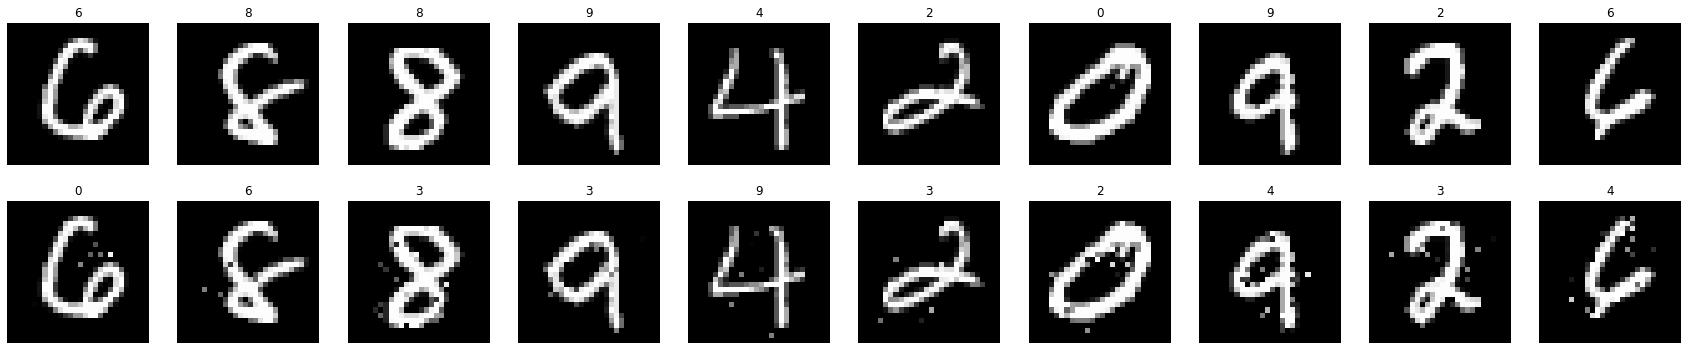

In [10]:
N_FIGS = 10
selected_indices = np.random.choice(SIZE, size=N_FIGS, replace=False)
fig, axs = plt.subplots(nrows=2, ncols=N_FIGS,figsize=(N_FIGS*3, 2*3 ))

for i in range(N_FIGS):
    axs[0,i].imshow(X_test[selected_indices[i]].reshape(28, 28),
                    interpolation='none', vmin=-1.0, vmax=1.0, cmap=plt.cm.gray_r)
    axs[0,i].set_title(str(y_pred[selected_indices[i]]))
    axs[0,i].axis('off')

    axs[1,i].imshow(X_adv[selected_indices[i]].reshape(28, 28),
                    interpolation='none', vmin=-1.0, vmax=1.0, cmap=plt.cm.gray_r)
    axs[1,i].set_title(str(adv_pred[selected_indices[i]]))
    axs[1,i].axis('off')
fig.show()

In [11]:
l2_norm = np.mean(np.linalg.norm(X_test[:SIZE] - X_adv, axis=1))
print('Average l2 norm = {:.3f}'.format(l2_norm))

Average l2 norm = 3.463
